<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/Practice/LSTM_univariate_single_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Practice 2

In [ ]:
## Importing dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [ ]:
## matplotlib parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
## file loading
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/LSTM_Prac/
df = pd.read_csv('jena_climate_2009_2016.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/LoadForecasting/LSTM_Prac


In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
## 훈련을 위한 파라미터 설정
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
## 학습 시 파라미터
EVALUATION_INTERVAL = 200
POCHS = 10

In [ ]:
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [ ]:
## time-series prediction of univariate value
uni_data = df['T (degC)']  # y value = temperature
uni_data.index = df['Date Time']  # x value= time-series
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [ ]:
## data arrangement
uni_data= uni_data.values

In [ ]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [ ]:
## data standardization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

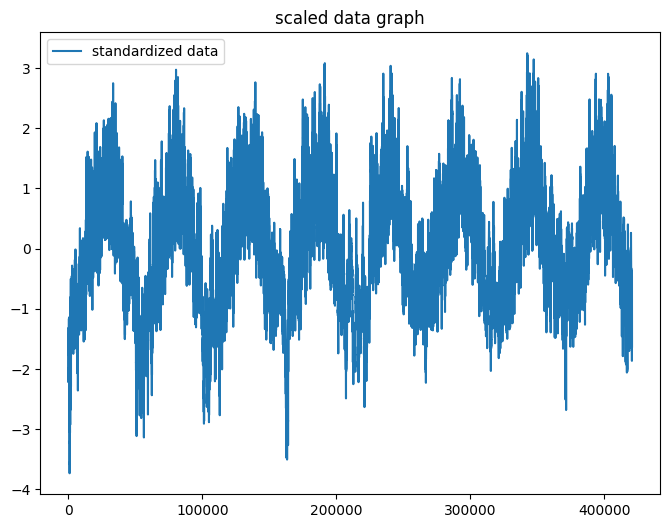

In [ ]:
plt.plot(np.arange(len(uni_data)), uni_data, label='standardized data')
plt.title('scaled data graph')
plt.legend()
plt.show()

In [ ]:
## data_window : data window의 크기 입니다 (하나의 데이터 윈도우에 몇 개의 데이터가 들어가는지)
## target : 예측해야하는 레이블 입니다.
def univariate_data(dataset, start_index, end_index, data_window, target):
  data, labels = [], []

  start_index = start_index + data_window
  if end_index is None:
    end_index = len(dataset) - target

  for i in range(start_index, end_index):
    indices = range(i-data_window, i)
    # Reshape data from (data_window,) to (data_window, 1)
    data.append(np.reshape(dataset[indices], (data_window, 1)))
    labels.append(dataset[i+target])
  return np.array(data), np.array(labels)

In [ ]:
data_window = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           data_window,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       data_window,
                                       univariate_future_target)

In [ ]:
print(x_train_uni.shape) # Input dimension= (20, 1) ## 299980 is batch size
print(y_train_uni.shape) # Input dimension= (1)

(299980, 20, 1)
(299980,)


In [ ]:
def baseline(history):
  return np.mean(history)

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

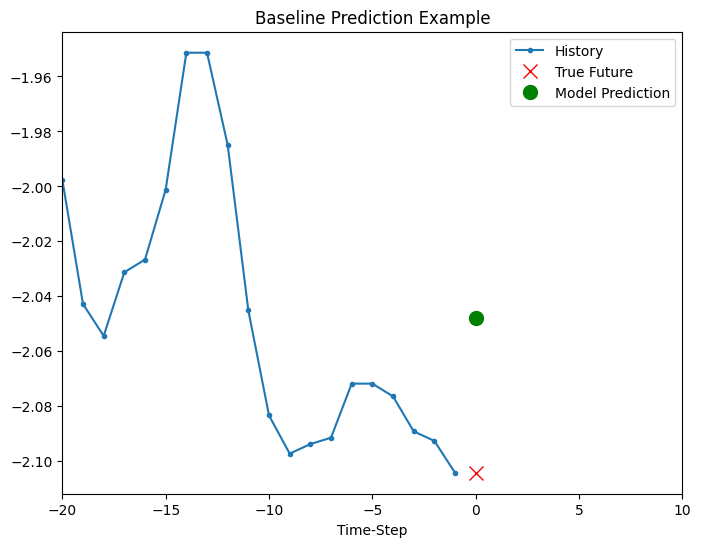

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
## model build
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

## model compile
simple_lstm_model.compile(optimizer='adam', loss='mae', metrics='mse')

## model fitting
history= simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 7s 13ms/step - loss: 0.5829 - mse: 0.6654 - val_loss: 0.1402 - val_mse: 0.0364
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1181 - mse: 0.0490 - val_loss: 0.0350 - val_mse: 0.0025
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0486 - mse: 0.0064 - val_loss: 0.0305 - val_mse: 0.0019
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0453 - mse: 0.0072 - val_loss: 0.0255 - val_mse: 0.0014
Epoch 5/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0304 - mse: 0.0025 - val_loss: 0.0229 - val_mse: 0.0012
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0314 - mse: 0.0029 - val_loss: 0.0211 - val_mse: 0.0010
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0284 - mse: 0.0022 - val_loss: 0.0193 - val_mse: 8.4894e-04
Epoch 8/10
200/200 [==============================] - 2s 11ms/ste

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

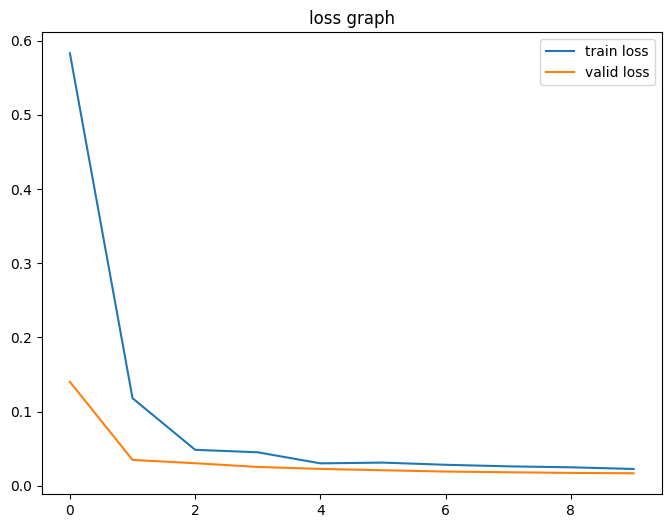

In [ ]:
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'], label='train loss')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'], label='valid loss')
plt.legend()
plt.title('loss graph')
plt.show()

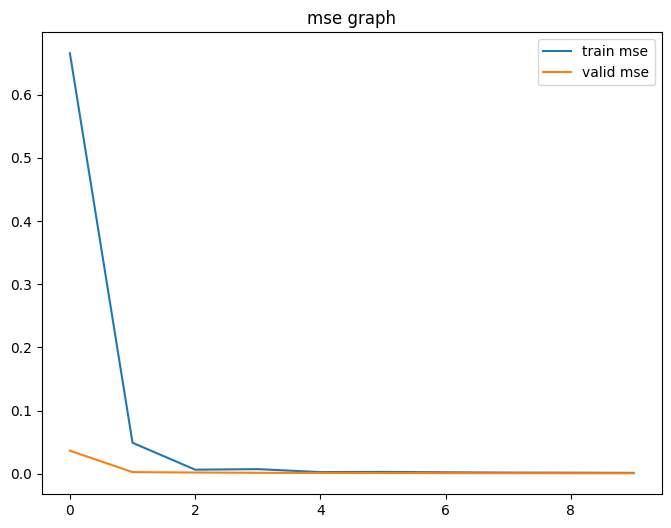

In [ ]:
plt.plot(np.arange(len(history.history['mse'])),history.history['mse'], label='train mse')
plt.plot(np.arange(len(history.history['val_mse'])),history.history['val_mse'], label='valid mse')
plt.legend()
plt.title('mse graph')
plt.show()

8/8 [==============================] - 2s 7ms/step


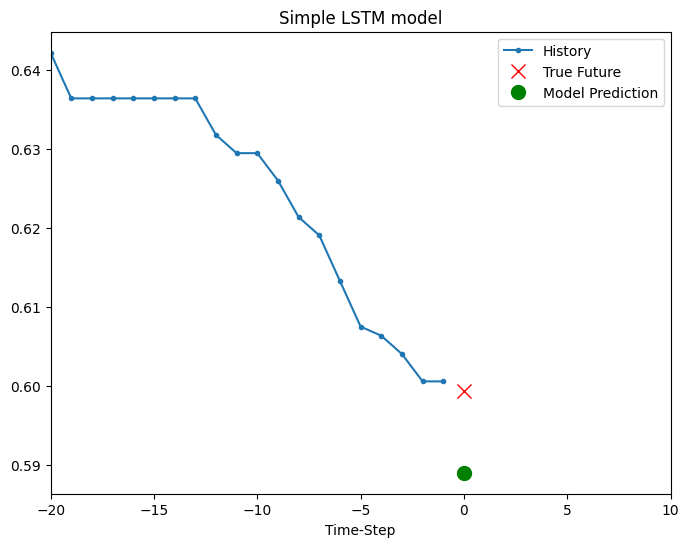

8/8 [==============================] - 0s 5ms/step


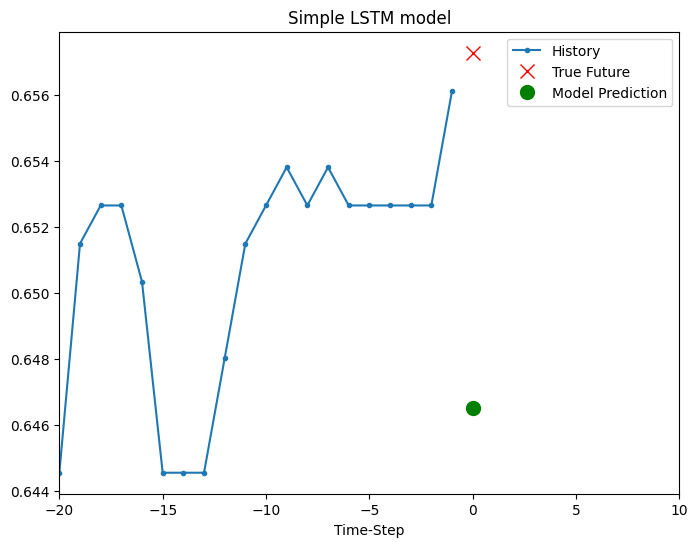

8/8 [==============================] - 0s 3ms/step


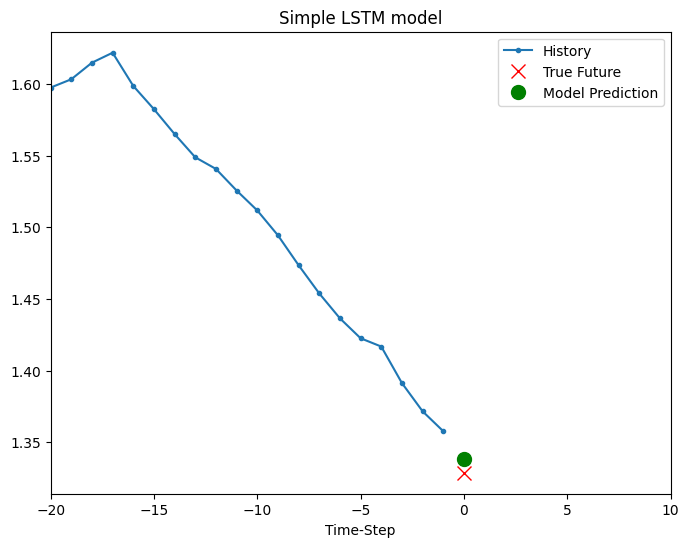

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()